# Exploring Ocean Composites

[Composites](https://docs.ocean.dwavesys.com/en/stable/concepts/samplers.html#composites) are available in several packages in the D-Wave Ocean SDK.
Composites inherit their name from the design pattern they follow, the [Composite Pattern](https://en.wikipedia.org/wiki/Composite_pattern).

Using one or more composites, a sampler can be composed with a number of pre- and post-processing layers.

Note: As it stands, composites can only be used to compose [samplers](https://docs.ocean.dwavesys.com/en/stable/concepts/samplers.html#samplers) for Binary Quadratic Model problems.


## Composites covered in lecture material
This notebook covers several composites, exploring how they can be used and why they are useful:

* [StructureComposite](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampler_composites/composites.html#module-dimod.reference.composites.structure)
* [EmbeddingComposite](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#embeddingcomposite)
* [TruncateComposite](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampler_composites/composites.html#module-dimod.reference.composites.truncatecomposite)
* [FixVariablesComposite](https://docs.ocean.dwavesys.com/en/stable/docs_preprocessing/reference/composites.html#fix-variables-composite)
* [SteepestDescentComposite](https://docs.ocean.dwavesys.com/en/stable/docs_greedy/reference/composites.html#steepestdescentcomposite)


## 1) Structure Composite

The `StructureComposite` can be used to compose a sampler that targets a particular graph structure. The ability to do this is useful for simulating proposed working graphs of QPU designs. In this demonstration, we will show how to build a composed sampler using the Simulated Annealing Sampler and Structure Composite, targeting a 3 dimensional simple lattice structure. 

Lattice structures are particularly interesting due to the variety of applications in the sciences. To name a few:
- KT phase transition study on square-octagonal lattices (https://arxiv.org/abs/1803.02047)
- Lattice-based cryptography (https://en.wikipedia.org/wiki/Lattice-based_cryptography)
- Study of crystalline structures (https://en.wikipedia.org/wiki/Crystal_structure)

First, let's use NetworkX to build a lattice-structured graph for our composed simple 3d lattice sampler, and view the lattice in a 3d plot with matplotlib.

In [7]:
import dimod
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

<IPython.core.display.Javascript object>


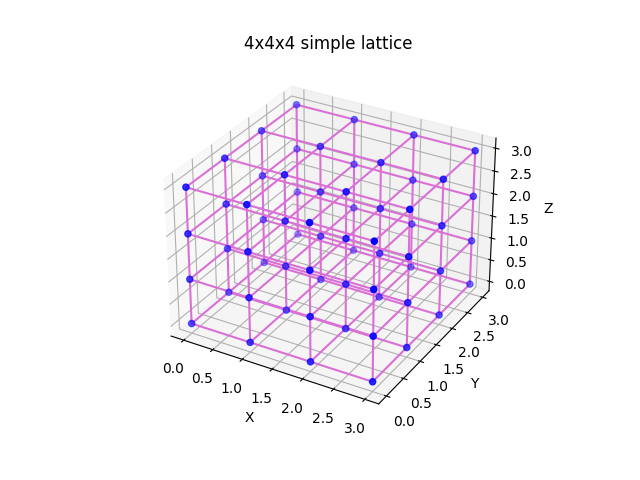

In [8]:
# Build a simple 3D lattice with grid_graph

lattice = nx.grid_graph(dim=(4,4,4))

%matplotlib notebook

nodes_xyz = np.array(lattice.nodes)
edges_xyz = np.array(lattice.edges)

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(xlabel="X", ylabel="Y", zlabel="Z",title="4x4x4 simple lattice")

#plot points
ax.scatter3D(nodes_xyz.T[0], nodes_xyz.T[1], nodes_xyz.T[2], c='b')

#plot the edges
for edge in edges_xyz:
    ax.plot3D(*zip(edge[0], edge[1]), color="orchid")

### Build a composed structured sampler

Now we are ready to build our composed structured sampler with our lattice graph.

Let's look at the signature of the `StructureComposite` class, found in `dimod`, to see what we need:

In [9]:
?dimod.StructureComposite

We provide a base sampler, in this case the `SimulatedAnnealingSampler` from `neal`, a list of nodes, and a list of edges.
The edge and node lists will come from our lattice graph.

In [10]:
from neal import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()

structured_sampler = dimod.StructureComposite(sampler, list(lattice.nodes), list(lattice.edges))

With the structured sampler ready, we can sample from Binary Quadratic Models with the same target graph.
Next, let's generate a random BQM that has the exact same graph as our structured sampler.

In [33]:
# Build a BQM with random biases and same structure as our structured sampler.

linear = {node:np.random.randint(-20,20) for node in lattice.nodes}
quadratic = {edge:np.random.randint(-20,20) for edge in lattice.edges}

bqm = dimod.BQM(linear, quadratic, "BINARY")

response = structured_sampler.sample(bqm, num_reads=10)

print(response)

  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) ... (19, 19, 19)   energy num_oc.
0         1         0         0         1 ...            1 -79343.0       1
3         1         0         0         1 ...            1 -79336.0       1
1         1         0         0         1 ...            1 -79332.0       1
2         1         0         0         1 ...            1 -79322.0       1
6         1         0         0         1 ...            1 -79317.0       1
8         1         0         0         1 ...            1 -79313.0       1
4         1         0         0         1 ...            1 -79311.0       1
5         1         0         0         1 ...            1 -79307.0       1
7         1         0         0         1 ...            1 -79303.0       1
9         1         0         0         1 ...            1 -79303.0       1
['BINARY', 10 rows, 10 samples, 8000 variables]


## 2) Embedding Composite

This is great! However, we are restricted to BQMs with a very specfic graph structure - one exactly matching the structured sampler. We can, however, exploit this structure in a meaningful way by composing our sampler with yet another composite - the `EmbeddingComposite`, found in the package `dwave-system`.

Looking at the signature tells us that we need to provide a *structured* sampler, among other optional arguments.
We require the input sampler to be structured, and it is worth mentioning that every QPU has a structure (Chimera, Pegasus are names of working graphs).

Our composed sampler has a lattice structure, so we can compose it with the `EmbeddingComposite` and embed problem graphs that are embeddable. This has the benefit of solving problems that don't have the exact same structure as the sampler.

In [12]:
from dwave.system import EmbeddingComposite

?EmbeddingComposite

Now, there may be many graphs that we can map to a lattice. Today, I though it would be interesting and perhaps motivating to show embedding the same structure of lattice, just of a smaller size. This motivates thinking of parallelization via structure.

First, let's build our composed embedding sampler, that looks to embed the input problem's graph into our original lattice graph.
Then, let's create a smaller 3d lattice to sample with the composed sampler.

In [13]:
embedding_sampler = EmbeddingComposite(structured_sampler)

# Create a smaller simple 3d lattice

lattice_small = nx.grid_graph(dim=(2,2,2))

linear_small = {node:np.random.randint(-20,20) for node in lattice_small.nodes}
quadratic_small = {edge:np.random.randint(-20,20) for edge in lattice_small.edges}

small_bqm = dimod.BQM(linear_small, quadratic_small, "BINARY")

response_embedded = embedding_sampler.sample(small_bqm, num_reads=10, return_embedding=True)

print(response_embedded)

  (0, 0, 0) (0, 0, 1) (0, 1, 0) (0, 1, 1) ... (1, 1, 1) energy num_oc. ...
0         1         1         1         1 ...         1  -75.0       1 ...
1         1         1         1         1 ...         1  -75.0       1 ...
2         1         1         1         1 ...         1  -75.0       1 ...
3         1         1         1         1 ...         1  -75.0       1 ...
4         1         1         1         1 ...         1  -75.0       1 ...
5         1         1         1         1 ...         1  -75.0       1 ...
6         1         1         1         1 ...         1  -75.0       1 ...
7         1         1         1         1 ...         1  -75.0       1 ...
8         1         1         1         1 ...         1  -75.0       1 ...
9         1         1         1         1 ...         1  -75.0       1 ...
['BINARY', 10 rows, 10 samples, 8 variables]


Let's visualize the embedding of the smaller lattice into the larger one:

<IPython.core.display.Javascript object>


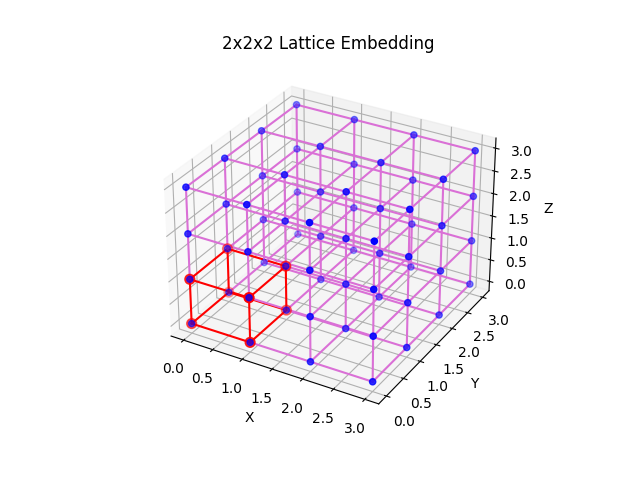

In [14]:
node_embedding = []
for embedding in response_embedded.info['embedding_context']['embedding'].values():
    node_embedding += [*embedding]
    
node_embedding = np.array(node_embedding)

%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(xlabel="X", ylabel="Y", zlabel="Z", title="2x2x2 Lattice Embedding")

#plot points
ax.scatter3D(nodes_xyz.T[0], nodes_xyz.T[1], nodes_xyz.T[2], c='b')
ax.scatter3D(node_embedding.T[0], node_embedding.T[1], node_embedding.T[2], s=50, c='r')

#plot the edges
for edge in edges_xyz:
    if any(np.array_equal(edge[0], x) for x in node_embedding) and any(np.array_equal(edge[1], x) for x in node_embedding):
        ax.plot3D(*zip(edge[0], edge[1]), "r")
    else:
        ax.plot3D(*zip(edge[0], edge[1]), color="orchid")

### Embedding with Chains

Sometimes, we need to embed a problem graph that could have a different topology, or a similar structure but with higher connectivity on average. In these situations, we could end up mapping a node in our problem graph to several nodes in our structured sampler's graph to account for the higher connectivity of nodes. This creates "chains" of nodes and edges that are used to represent a node in our problem graph via embedding.

Let's try to embed a 3d lattice that has periodic boundary conditions that result in some nodes with a higher maximum degree than in the simple case.

In [15]:
# Create a 3x2x2 lattice with periodic boundary conditions

periodic_lattice = nx.grid_graph(dim=(3,2,2), periodic=True)

linear_periodic = {node:np.random.randint(-20,20) for node in periodic_lattice.nodes}
quadratic_periodic = {edge:np.random.randint(-20,20) for edge in periodic_lattice.edges}

periodic_lattice_bqm = dimod.BQM(linear_periodic, quadratic_periodic, "BINARY")

response_embedded = embedding_sampler.sample(periodic_lattice_bqm, num_reads=10, return_embedding=True)

print(response_embedded)

  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 1, 0) ... (1, 1, 2) energy num_oc. ...
0         1         1         1         1 ...         0 -134.0       1 ...
1         1         1         1         1 ...         0 -134.0       1 ...
3         1         1         1         1 ...         0 -134.0       1 ...
4         1         1         1         1 ...         0 -134.0       1 ...
6         1         1         1         1 ...         0 -134.0       1 ...
7         1         1         1         1 ...         0 -134.0       1 ...
8         1         1         1         1 ...         0 -134.0       1 ...
9         1         1         1         1 ...         0 -134.0       1 ...
2         1         1         1         0 ...         0 -130.0       1 ...
5         1         1         1         1 ...         0 -129.0       1 ...
['BINARY', 10 rows, 10 samples, 12 variables]


In [16]:
response_embedded.info['embedding_context']['embedding']

{(1, 0, 0): ((1, 2, 2), (1, 2, 3), (2, 2, 3)),
 (0, 0, 0): ((3, 2, 3), (3, 2, 2)),
 (0, 1, 0): ((2, 2, 1), (3, 2, 1)),
 (0, 0, 1): ((2, 1, 2), (2, 2, 2)),
 (0, 0, 2): ((2, 3, 2), (3, 3, 2)),
 (1, 0, 1): ((1, 1, 2), (0, 1, 2)),
 (0, 1, 1): ((2, 1, 0), (2, 2, 0), (2, 1, 1)),
 (1, 0, 2): ((0, 3, 2), (1, 3, 2), (0, 2, 2)),
 (0, 1, 2): ((2, 3, 0), (2, 3, 1)),
 (1, 1, 0): ((1, 2, 1),),
 (1, 1, 1): ((1, 1, 0), (1, 1, 1)),
 (1, 1, 2): ((1, 3, 0), (1, 3, 1), (1, 2, 0))}

Above, we see that some of the nodes from our input graph are mapped to sometimes several nodes in our structured sampler's graph. These input nodes have a higher degree than is available on any node in our structured sampler's graph.

The visualization becomes pretty messy, but let's take a look at how the embedding worked out in this more complex case.
We end up mapping single nodes in the `periodic_lattice_bqm` graph to multiple nodes in our structured sampler's graph due to the periodic boundary conditions. These are known as chains in embedding; using multiple nodes and edges to represent one node.

<IPython.core.display.Javascript object>


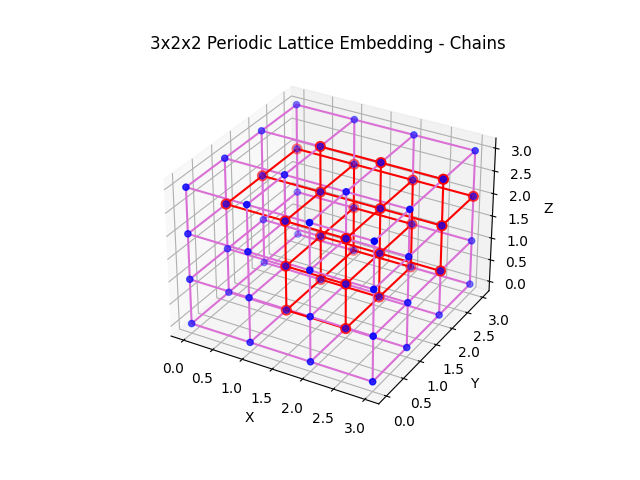

In [17]:
node_embedding = []
for embedding in response_embedded.info['embedding_context']['embedding'].values():
    node_embedding += [*embedding]
    
node_embedding = np.array(node_embedding)

%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(xlabel="X", ylabel="Y", zlabel="Z", title="3x2x2 Periodic Lattice Embedding - Chains")

#plot points
ax.scatter3D(nodes_xyz.T[0], nodes_xyz.T[1], nodes_xyz.T[2], c='b')
ax.scatter3D(node_embedding.T[0], node_embedding.T[1], node_embedding.T[2], s=50, c='r')

#plot the edges
for edge in edges_xyz:
    if any(np.array_equal(edge[0], x) for x in node_embedding) and any(np.array_equal(edge[1], x) for x in node_embedding):
        ax.plot3D(*zip(edge[0], edge[1]), "r")
    else:
        ax.plot3D(*zip(edge[0], edge[1]), color="orchid")

## 3) TruncateComposite

To cap it off, let's take a look at another composite that acts as a post-processing layer. The `TruncateComposite` found in `dimod` allows us to filter the returned sample set, for example if we only care about a few of the lowest energy samples returned.

The signature shows us we need to provide a sampler and number of rows to return, with some other optional arguments.

In [18]:
?dimod.TruncateComposite

In [19]:
truncated_sampler = dimod.TruncateComposite(embedding_sampler, 5)

response_truncated = truncated_sampler.sample(small_bqm, num_reads=10)

print(response_truncated)

  (0, 0, 0) (0, 0, 1) (0, 1, 0) (0, 1, 1) ... (1, 1, 1) energy num_oc. ...
0         1         1         1         1 ...         1  -75.0       1 ...
1         1         1         1         1 ...         1  -75.0       1 ...
2         1         1         1         1 ...         1  -75.0       1 ...
3         1         1         1         1 ...         1  -75.0       1 ...
4         1         1         1         1 ...         1  -75.0       1 ...
['BINARY', 5 rows, 5 samples, 8 variables]


## 4) FixVariablesComposite

The `FixVariablesComposite` allows users to 'fix' some variables of a binary quadratic model (BQM) before it is passed to a sampler, guaranteeing that returned samples will include the fixed variables. 

By fixing variables, we are reducing the size of the problem that actually needs to be solved. This is especially helpful for larger problems that cannot be easily solved on the QPU. 

The `FixVariablesComposite` can be found in dwave.preprocessing, where many of Ocean's pre-processing composites are located.

In [34]:
from dwave.preprocessing import FixVariablesComposite

Here is its class signature:

In [21]:
?FixVariablesComposite

The `FixVariablesComposite` requires the user to specify a child sampler and the algorithm that determines which variables to fix. 

We can demonstrate this with a toy BQM of one ising variable.

In [35]:
import dimod
bqm = dimod.BinaryQuadraticModel.from_ising({'a':1}, {})

We'll use the `ExactSolver` from `dimod` as the child sampler, which is great for testing small problems because it calculates the energy for every possible sample.

In [36]:
from dimod import ExactSolver

exact_solver = ExactSolver()
sampler = FixVariablesComposite(exact_solver, algorithm='explicit')

By default, `algorithm` is set to `explicit`, meaning that the user must explicitly pass in a `fixed_variables` dict when sampling, as seen below:

In [37]:
# Using only the ExactSolver
sampleset = exact_solver.sample(bqm)
print(sampleset)

# Using the FixVariablesComposite and fixing the one variable to -1
sampleset = sampler.sample(bqm, fixed_variables={'a':-1})
print(sampleset)

   a energy num_oc.
0 -1   -1.0       1
1 +1    1.0       1
['SPIN', 2 rows, 2 samples, 1 variables]
   a energy num_oc.
0 -1   -1.0       1
['SPIN', 1 rows, 1 samples, 1 variables]


Instead of passing in the fixed variables explicitly, `algorithm` can also be set to `roof_duality`. With this algorithm, the composite will try to find minimizing assignments for some or all of the BQM's variables. For more information on the roof duality algorithm, see `roof_duality()` (TODO: add link to docs).

In [38]:
sampler = FixVariablesComposite(exact_solver, algorithm='roof_duality')
sampleset = sampler.sample(bqm)
print(sampleset)

strict:  True
num fixed vars: 1
   a energy num_oc.
0 -1   -1.0       1
['SPIN', 1 rows, 1 samples, 1 variables]


By default, we run the roof duality algorithm in `strict` mode. This means that we only fix variables when the variable assignments are True for all ground states. To demonstrate this, let's pick a different BQM:

In [39]:
bqm = dimod.BinaryQuadraticModel.from_ising({}, {'ab':-1})

This BQM has two ground states, either both `a` and `b` are -1 or both `a` and `b` are +1, which means that there are no variables that have a single value for all ground states. Thus, when `strict=True`, we don't have any fixed variables:

In [40]:
sampleset = sampler.sample(bqm, strict=True)
print(sampleset)

strict:  True
num fixed vars: 0
   a  b energy num_oc.
0 -1 -1   -1.0       1
2 +1 +1   -1.0       1
1 +1 -1    1.0       1
3 -1 +1    1.0       1
['SPIN', 4 rows, 4 samples, 2 variables]


When `strict=False`, we also fix the variables with assignments that are True for some but not all ground states.

In [28]:
sampleset = sampler.sample(bqm, strict=False)
print(sampleset)

strict:  False
num fixed vars: 2
   a  b energy num_oc.
0 -1 -1   -1.0       1
['SPIN', 1 rows, 1 samples, 2 variables]


Now let's test the composite out on a larger problem. We go back to our lattices:

In [42]:
# Build a BQM from a 3D lattice
lattice = nx.grid_graph(dim=(20,20,20))

linear = {node:np.random.randint(-50,50) for node in lattice.nodes}
quadratic = {edge:np.random.randint(-50,50) for edge in lattice.edges}

bqm = dimod.BinaryQuadraticModel(linear, quadratic, "BINARY")

# Solve with SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=5)
print(sampleset)

# Add the FixVariablesComposite
fixed_sampler = FixVariablesComposite(sampler, algorithm='roof_duality')
sampleset = fixed_sampler.sample(bqm, strict=True, num_reads=5)
print(sampleset)

  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) ... (19, 19, 19)    energy num_oc.
2         1         0         1         0 ...            1 -193558.0       1
3         1         1         0         0 ...            1 -193536.0       1
4         1         0         1         0 ...            1 -193505.0       1
1         1         0         1         0 ...            1 -193503.0       1
0         1         0         1         0 ...            1 -193487.0       1
['BINARY', 5 rows, 5 samples, 8000 variables]
strict:  True
num fixed vars: 7659
  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) ... (19, 19, 19)    energy num_oc.
1         1         0         1         0 ...            1 -193644.0       1
0         1         0         1         0 ...            1 -193641.0       1
2         1         0         1         0 ...            1 -193633.0       1
3         1         0         1         0 ...            1 -193633.0       1
4         1         0         1         0 ...            1 -193626.0    

## 5) SteepestDescentComposite

We can also do some post-processing optimization to make local improvements. The `SteepestDescentComposite` runs a greedy local optimization on a problem by taking samples from a child sampler as initial states.

The `SteepestDescentComposite` can be found in `dwave-greedy`.

In [44]:
from greedy import SteepestDescentComposite

Here is its class signature:

In [ ]:
?SteepestDescentComposite

For this example, let's use the `DWaveSampler` as our child sampler. Our problem graph is incompatible with the QPU architecture, so we'll also have to use the `EmbeddingComposite`.

In [47]:
from dwave.system import DWaveSampler, EmbeddingComposite

sampler = EmbeddingComposite(DWaveSampler())

Embedding a lattice onto the QPU can take a while, so let's use a smaller 3D lattice this time around.

In [48]:
# Build a BQM from a 3D lattice
lattice = nx.grid_graph(dim=(5,5,5))

linear = {node:np.random.randint(-100,100) for node in lattice.nodes}
quadratic = {edge:np.random.randint(-100,100) for edge in lattice.edges}

bqm = dimod.BinaryQuadraticModel(linear, quadratic, "BINARY")

Now let's compare the results with post-processing and without.

In [49]:
# Solve with DWaveSampler
sampleset = sampler.sample(bqm, num_reads=10)
print(sampleset)

# Solve with the SteepestDescentComposite
greedy_sampler = SteepestDescentComposite(sampler)
sampleset = greedy_sampler.sample(bqm, num_reads=10)
print(sampleset)

  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) ... (4, 4, 4)  energy num_oc. ...
0         0         0         0         1 ...         1 -5827.0       1 ...
1         0         0         0         1 ...         1 -5820.0       1 ...
2         0         0         1         1 ...         1 -5790.0       1 ...
3         0         0         1         1 ...         1 -5776.0       1 ...
4         0         0         0         1 ...         1 -5775.0       1 ...
5         0         0         0         1 ...         1 -5770.0       1 ...
6         0         0         1         1 ...         1 -5745.0       1 ...
7         0         0         0         1 ...         1 -5739.0       1 ...
8         0         0         1         1 ...         1 -5675.0       1 ...
9         0         0         1         1 ...         1 -5662.0       1 ...
['BINARY', 10 rows, 10 samples, 125 variables]
  (0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) ... (4, 4, 4)  energy num_oc. ...
8         0         0         0         1